# 微调

## 导入基本包

In [1]:
%matplotlib inline

import os
import torch
import torchvision
from torch import nn
import d2l_torch as d2l

## 数据集

从网上弄得一个数据集，热狗（火腿肠）
+ 下载链接：< http://d2l-data.s3-accelerate.amazonaws.com/hotdog.zip>
+ 如果下载速度慢的话，直接迅雷或者浏览器下载吧

In [2]:
d2l.DATA_HUB['hotdog'] = (d2l.DATA_URL + 'hotdog.zip',
                          'fba480ffa8aa7e0febbb511d181409f899b9baa5')

data_dir = d2l.download_extract('hotdog')

In [3]:
train_imgs = torchvision.datasets.ImageFolder(os.path.join(data_dir, 'train'))
test_imgs = torchvision.datasets.ImageFolder(os.path.join(data_dir, 'test'))

`ImageFolder`适合以文件夹为单位组织的图片，
+ 比如：`root/dog/xxx.png`或者是`root/cat/123.png`，或者是文件夹下面的子文件夹的图片，`root/dog/[...]/xxz.png`
+ 或者上面代码是：
    + `./data/hotdog/test/hotdog`和`./data/hotdog/test/not-hotdog`，以及
    + `./data/hotdog/train/hotdog`和`./data/hotdog/train/not-hotdog`

+ 所以这其实是个分类问题，是**热狗图片**，还是**不是热狗图片**
+ 不是目标检测问题，如果是目标检测的话，还会有xml或者其它标记位置信息的文件

## 查看数据集

In [4]:
train_imgs[1]

(<PIL.Image.Image image mode=RGB size=155x98 at 0x1DEB8C773C8>, 0)

**注意**：
+ `/train/`文件夹中包含`hotdog`和`not-hotdog`两个文件夹
+ 所以ImageFolder会逐个读取这两个文件夹中的图片，即从1开始到1000，是hotdog图片，从1001到2000是not-hotdog。
+ 也就是正着数前1k张图是热狗，倒着数前1k张图是 非热狗

array([<matplotlib.axes._subplots.AxesSubplot object at 0x000001DEB99B2808>,
      dtype=object)

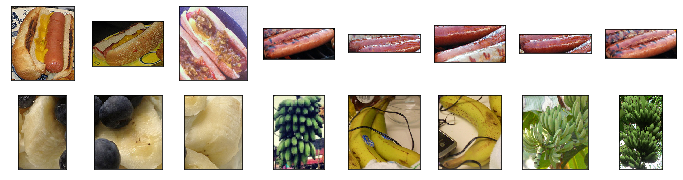

In [6]:
hotdogs=[train_imgs[i][0] for i in range(8)]
not_hotdogs=[train_imgs[-i-1][0] for i in range(8)]
d2l.show_images(hotdogs+not_hotdogs,2,8)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x000001DEBD2A9148>,
      dtype=object)

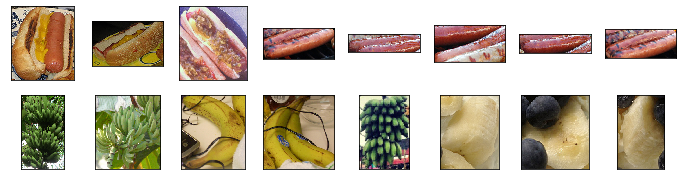

In [9]:
hotdogs=[train_imgs[i][0] for i in range(8)]
not_hotdogs=[train_imgs[1992+i][0] for i in range(8)]
d2l.show_images(hotdogs+not_hotdogs,2,8)

可以看到，其实效果差不多，只不过上面是not-hotdog倒过来了。

二分类：
+ 正例就是：热狗
+ 负例就是：非热狗，比如一些和热狗有点相似的东西：香蕉（绿色或者黄色的），或者是剥了皮的香蕉

图像质量：
+ 长宽比差距很大，
+ 图像中香肠占比也不同
+ 图像大小差距也很大

## 计算热狗数据集的均值和方差

In [20]:
augs=torchvision.transforms.ToTensor()
augs(train_imgs[1][0])

tensor([[[0.0078, 0.0078, 0.0039,  ..., 0.3765, 0.2549, 0.2078],
         [0.0039, 0.0039, 0.0039,  ..., 0.2000, 0.2392, 0.3137],
         [0.0039, 0.0039, 0.0039,  ..., 0.0275, 0.0784, 0.3137],
         ...,
         [0.6431, 0.6510, 0.6471,  ..., 0.3765, 0.3725, 0.3608],
         [0.6275, 0.6392, 0.6431,  ..., 0.3176, 0.3216, 0.3529],
         [0.6235, 0.6275, 0.6392,  ..., 0.2980, 0.3216, 0.2392]],

        [[0.0078, 0.0078, 0.0039,  ..., 0.3686, 0.2314, 0.1608],
         [0.0039, 0.0039, 0.0039,  ..., 0.2039, 0.2235, 0.2745],
         [0.0039, 0.0039, 0.0039,  ..., 0.0275, 0.0745, 0.2980],
         ...,
         [0.5725, 0.5765, 0.5765,  ..., 0.3059, 0.3020, 0.2902],
         [0.5529, 0.5608, 0.5647,  ..., 0.2588, 0.2549, 0.2824],
         [0.5451, 0.5490, 0.5529,  ..., 0.2275, 0.2471, 0.1608]],

        [[0.0078, 0.0078, 0.0039,  ..., 0.3216, 0.1765, 0.1059],
         [0.0039, 0.0039, 0.0039,  ..., 0.1804, 0.1804, 0.2275],
         [0.0039, 0.0039, 0.0039,  ..., 0.0196, 0.0549, 0.

In [32]:
augs(train_imgs[1][0])*255

tensor([[[  2.,   2.,   1.,  ...,  96.,  65.,  53.],
         [  1.,   1.,   1.,  ...,  51.,  61.,  80.],
         [  1.,   1.,   1.,  ...,   7.,  20.,  80.],
         ...,
         [164., 166., 165.,  ...,  96.,  95.,  92.],
         [160., 163., 164.,  ...,  81.,  82.,  90.],
         [159., 160., 163.,  ...,  76.,  82.,  61.]],

        [[  2.,   2.,   1.,  ...,  94.,  59.,  41.],
         [  1.,   1.,   1.,  ...,  52.,  57.,  70.],
         [  1.,   1.,   1.,  ...,   7.,  19.,  76.],
         ...,
         [146., 147., 147.,  ...,  78.,  77.,  74.],
         [141., 143., 144.,  ...,  66.,  65.,  72.],
         [139., 140., 141.,  ...,  58.,  63.,  41.]],

        [[  2.,   2.,   1.,  ...,  82.,  45.,  27.],
         [  1.,   1.,   1.,  ...,  46.,  46.,  58.],
         [  1.,   1.,   1.,  ...,   5.,  14.,  65.],
         ...,
         [ 18.,  16.,  13.,  ...,   6.,   5.,   2.],
         [ 10.,  10.,   9.,  ...,   1.,   9.,  22.],
         [  6.,   5.,   6.,  ...,  20.,  33.,  16.]]]

In [38]:
import torch
from torchvision import datasets, transforms
from torch.utils.data.dataset import Dataset
import os

# 把文件夹图像数据转成Tensor
augs=torchvision.transforms.ToTensor()
train_length=len(train_imgs)
train_imgs_tensor=[augs(train_imgs[i][0]) for i in range(train_length)]

# 构建dataloader
train_loader = torch.utils.data.DataLoader(train_imgs_tensor, shuffle=False, num_workers=os.cpu_count())


# 创建三通道的均值和方差向量
mean = torch.zeros(3)
std = torch.zeros(3)

# 开始计算
for X in train_loader:
    for d in range(3):
        mean[d] += X[:, d, :, :].mean() 
        std[d] += X[:, d, :, :].std()
mean.div_(train_length)
std.div_(train_length)
print(f"均值为：{mean}，方差为：{std}")

均值为：tensor([0.5734, 0.4586, 0.2882])，方差为：tensor([0.2108, 0.2169, 0.1982])


In [30]:
for X in train_loader:
    print(X.shape)
    break

torch.Size([1, 3, 144, 122])


**可以看到**
+ 均值为：tensor([0.5734, 0.4586, 0.2882])，方差为：tensor([0.2108, 0.2169, 0.1982])
+ 原始的热狗数据集的数值范围已经是0-1了，计算得到的均值和方差其实和ImageNet的或者COCO的还是有接近之处的
+ 结合CSDN文章：[计算图像数据集的均值和方差(mean, std)用于transforms.Normalize()标准化](https://blog.csdn.net/PanYHHH/article/details/107896526)
    + 这里用cifar10作为示例
    + 我看了36.数据增强中 cifar10的数据集，数值范围也已经被缩放到0-1了
+ 👍**所以图像数据集均值和方差的计算是在已经缩放到0-1之间的基础上？？**
    + 尝试过乘以255，结果会非常大。均值变大，方差也会很大（几百的样子）

imagenet的 RGB模式

              std标准差：[0.229, 0.224, 0.225]

              mean均值：[0.485, 0.456, 0.406]

COCO的RGB模式【很少用】

              std标准差： [0.234, 0.239, 0.242]

              mean均值：[0.471, 0.448, 0.408]

## 图像增广

因为使用的是ImageNet的预训练模型，所以数据增强也要和人家一致

对于`train_augs`
+ ImageNet的数据均值和方差就是下面这个值，有闲情的话可以算一遍。。。
+ 使用随机采集，同时resize到224，热狗数据集其实大小差距还挺大，这里直接都resize成224\*224，和ImageNet一致。。（都是为了适应那个预训练模型）
+ 用一个水平翻转，热狗这个物体翻转其实还好，因为本身是个比较对称的东西，默认翻转概率0.5

对于`test_augs`
+ 因为输入的图片大小也是不确定的，输入一个值的话，就是把短边弄成这个长度，另一个边在保持长宽比的情况下，去匹配这个值。
+ 先弄成256，再随机挖一个，不是从中心挖，就是随便挖。（如果希望从中间挖，可以去适当设置一下padding，这样就会相对靠近中心）

In [5]:
normalize=torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

train_augs=torchvision.transforms.Compose([torchvision.transforms.RandomResizedCrop(224),
                                          torchvision.transforms.RandomHorizontalFlip(),
                                          torchvision.transforms.ToTensor(),
                                          normalize])

test_augs=torchvision.transforms.Compose([torchvision.transforms.Resize(256),
                                         torchvision.transforms.RandomCrop(224),
                                         torchvision.transforms.ToTensor(),
                                         normalize])

## 定义和初始化模型

In [9]:
pretrained_net=torchvision.models.resnet18(pretrained=True,progress=True)

+ pretrained默认为False，只会下载网络结构
+ 为true的时候，则除了网络结构之外，还会下载 权重文件，
+ 而且会直接加载到内存里，可以直接访问权重参数等的值

In [43]:
pretrained_net.fc

Linear(in_features=512, out_features=1000, bias=True)

### 定义fine_tune模型

+ 最后一个fc分类层的输入，还是和预训练模型一样
+ 输出不再是ImageNet的1000类，而是这个热狗数据集的2类
+ 另外改完最后一层的结构之后，把它的权重随机初始化；其它层还是直接用pretrained模型自带的那些

In [4]:
finetune_net=torchvision.models.resnet18(pretrained=True)
finetune_net.fc=nn.Linear(finetune_net.fc.in_features,2) 
nn.init.xavier_uniform_(finetune_net.fc.weight)

Parameter containing:
tensor([[-0.0359,  0.0960,  0.0897,  ...,  0.0467, -0.0362,  0.0204],
        [ 0.0491,  0.1007, -0.0365,  ...,  0.0878, -0.0220,  0.0678]],
       requires_grad=True)

### 查看权重

In [76]:
named_param=pretrained_net.named_parameters()

In [83]:
next(named_param)[0]  # 每次调用会取出一个权重参数的名称，和下面的keys是一致的

'layer1.0.conv2.weight'

In [52]:
pretrained_net.state_dict().keys()

odict_keys(['conv1.weight', 'bn1.weight', 'bn1.bias', 'bn1.running_mean', 'bn1.running_var', 'bn1.num_batches_tracked', 'layer1.0.conv1.weight', 'layer1.0.bn1.weight', 'layer1.0.bn1.bias', 'layer1.0.bn1.running_mean', 'layer1.0.bn1.running_var', 'layer1.0.bn1.num_batches_tracked', 'layer1.0.conv2.weight', 'layer1.0.bn2.weight', 'layer1.0.bn2.bias', 'layer1.0.bn2.running_mean', 'layer1.0.bn2.running_var', 'layer1.0.bn2.num_batches_tracked', 'layer1.1.conv1.weight', 'layer1.1.bn1.weight', 'layer1.1.bn1.bias', 'layer1.1.bn1.running_mean', 'layer1.1.bn1.running_var', 'layer1.1.bn1.num_batches_tracked', 'layer1.1.conv2.weight', 'layer1.1.bn2.weight', 'layer1.1.bn2.bias', 'layer1.1.bn2.running_mean', 'layer1.1.bn2.running_var', 'layer1.1.bn2.num_batches_tracked', 'layer2.0.conv1.weight', 'layer2.0.bn1.weight', 'layer2.0.bn1.bias', 'layer2.0.bn1.running_mean', 'layer2.0.bn1.running_var', 'layer2.0.bn1.num_batches_tracked', 'layer2.0.conv2.weight', 'layer2.0.bn2.weight', 'layer2.0.bn2.bias', '

随便看一个权重，都很长，没有长度比较短的。

In [55]:
pretrained_net.state_dict()['bn1.running_mean']

tensor([ 2.7681e-03, -2.5769e-02,  2.1254e-07, -8.4605e-02,  2.1121e-08,
         4.9691e-04, -2.2408e-02, -1.1582e-07, -4.8239e-03,  2.7507e-07,
         3.9582e-02,  3.1994e-02, -3.7490e-02, -1.3716e-06,  6.6002e-03,
         4.3782e-03,  6.4797e-02,  1.1176e-01,  3.6002e-02, -7.5075e-02,
        -3.8240e-02,  8.4358e-02, -5.2287e-02, -1.1799e-02,  1.3019e-03,
         3.2172e-02, -1.7784e-02, -9.1009e-02,  1.1319e-01, -4.1632e-02,
         8.7302e-03,  2.9693e-02, -7.0502e-02, -3.4847e-03,  1.0977e-01,
        -1.7341e-03, -5.9423e-08,  2.9330e-02, -7.8553e-09,  6.7320e-03,
        -3.7100e-03,  1.6028e-02, -2.7883e-02,  2.6593e-02,  2.8475e-02,
        -1.2735e-01,  4.4617e-02,  2.6329e-02,  2.1454e-08, -1.7045e-02,
        -3.5617e-03, -4.5841e-02,  6.3876e-02,  1.5220e-02, -3.8511e-02,
        -1.6428e-02, -1.6569e-02,  5.6057e-02, -8.0306e-02, -2.6646e-03,
        -4.1718e-02,  1.2611e-01, -4.9237e-02, -1.3261e-02])

In [61]:
pretrained_net.bn1

BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)

不过那些`layer4.1.bn2.num_batches_tracked`这种，是没有办法访问的，`layer4.1`这个应该是submodule吧。❓❓❓

## 微调模型

+ `nn.CrossEntropyLoss(reduction="none")` # 数据简化 ; 数据整理，默认是求出损失的均值，这里不进行任何操作
+ `torch.optim.SGD`部分，
    + 除了fc层之外的层的参数是用1倍学习率，fc层是用10倍学习率，
    + 同时还使用了l2正则来限制参数范围，防止过拟合，也可以写成`1e-3`

In [3]:
def train_fine_tuning(net,lr,batch_size=128,num_epochs=5,param_group=True):
    """
    大部分和之前都差不多，不过有一个param_group，用来区分fc层和其它层学习率的参数
    非fc层是小的学习率，fc层的学习率是其它层的学习率的10倍
    因此非fc层是 1x，而fc层是10x（表示1倍学习率和10倍学习率）
    """
    train_iter = torch.utils.data.DataLoader(torchvision.datasets.ImageFolder(os.path.join(data_dir, 'train'),transform=train_augs),
        batch_size=batch_size, shuffle=True)
    test_iter = torch.utils.data.DataLoader(torchvision.datasets.ImageFolder(os.path.join(data_dir, 'test'),transform=test_augs),
        batch_size=batch_size)
    
    devices = d2l.try_all_gpus()
    loss = nn.CrossEntropyLoss(reduction="none") 
    if param_group:
        params_1x = [param for name, param in net.named_parameters() if name not in ["fc.weight", "fc.bias"]]
        trainer=torch.optim.SGD([{'params': params_1x}, {'params': net.fc.parameters(),'lr': lr * 10}],lr=lr,weight_decay=0.001)
    else:
        trainer=torch.optim.SGD(net.parameters(),lr=lr,weight_decay=0.001)
    d2l.train_ch13(net, train_iter, test_iter, loss, trainer, num_epochs,devices)

loss 0.173, train acc 0.930, test acc 0.931
170.2 examples/sec on [device(type='cuda', index=0)]


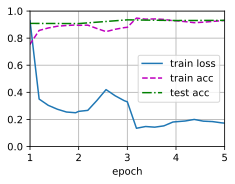

In [6]:
train_fine_tuning(finetune_net, batch_size=64,lr=5e-5)

+ 由于有过去的权重（特征提取部分），所以一开始准确率就很高
+ 而且其实到了第2个epoch，就已经很好，可能都不用跑5个epoch。
+ 而且没有很明显的过拟合现象，训练和测试结果都不错。
    + 测试精度还比训练精度高，
    + 虽然是ImageNet上的预训练模型，但是我们学习率用的很小，所以基本没有过拟合

In [10]:
print(5e-5*10)

0.0005


## 比较

为了进行比较，看一下不用预训练模型，全部随机初始化参数，和用了预训练模型的区别

In [13]:
torch.cuda.empty_cache()

loss 0.393, train acc 0.836, test acc 0.839
172.1 examples/sec on [device(type='cuda', index=0)]


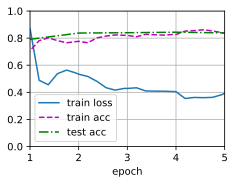

In [6]:
scratch_net = torchvision.models.resnet18()
scratch_net.fc = nn.Linear(scratch_net.fc.in_features, 2)
train_fine_tuning(scratch_net, batch_size=64,lr=5e-4, param_group=False)

可以看到：
+ 随机初始化，开始的准确率也也很高。。。。（所以凯明初始化很牛逼？？？）,
+ **因为这是个二分类问题，正常基础都是50%的正确类，网络结构只要不太差，其实都是60%多准确率**
+ 这里学习率其实有点不公平，应该可以再大一点的，因为不是微调了
+ 都是测试集比训练集高，数据增强还是有用的。
+ 可以看到，**用了预训练模型，能高10个点差不多**

In [10]:
for param in scratch_net.parameters():
    param.requires_grad = False

weight = pretrained_net.fc.weight
hotdog_w = torch.split(weight.data, 1, dim=0)[713]
hotdog_w.shape

torch.Size([1, 512])

这部分代码在代码slides里有，但是没有讲是干嘛的。大概就是看一下最后预训练模型和自己训练出来的模型的参数形状吧

# 验证

## ImageNet数据集的均值和方差

就是闲的，刚好充分利用一下自己电脑的计算资源，跑一下好了

看到沐神的代码，可以有个改进版本

In [3]:
import torch
import torchvision
from torchvision import datasets, transforms
from torch.utils.data.dataset import Dataset
import os

In [6]:
all_images=torchvision.datasets.ImageNet(root="../data",train=True,download=True) 

RuntimeError: The dataset is no longer publicly accessible. You need to download the archives externally and place them in the root directory.

根据：[Pytorch ImageNet dataset](https://stackoverflow.com/questions/60607824/pytorch-imagenet-dataset)
+ 这个问题似乎一年前就出现了。。。可能是无法使用了，只能自己提前下好，放到对应的文件夹里。

## CIFAR10数据集的均值和方差

In [11]:
# 其实在读取数据的时候，就可以转换成张量
dataset=torchvision.datasets.CIFAR10(root="../data",train=True,transform=torchvision.transforms.ToTensor(),download=True)
dataloader=torch.utils.data.DataLoader(dataset,batch_size=1,num_workers=4)

train_length=len(dataset)
mean = torch.zeros(3)
std = torch.zeros(3)

# 开始计算
for X, _ in dataloader:
    for d in range(3):
        mean[d] += X[:, d, :, :].mean() 
        std[d] += X[:, d, :, :].std()
mean.div_(train_length)
std.div_(train_length)
print(f"均值为：{mean}，方差为：{std}")

Files already downloaded and verified
均值为：tensor([0.4914, 0.4822, 0.4465])，方差为：tensor([0.2023, 0.1994, 0.2010])


In [19]:
dataset[1][0].shape[0]

3

## 从文件夹读取图像数据集计算均值和方差

其实也很简单，就是制作dataloader的时候，稍微有点差别

In [20]:
import torch
from torchvision import datasets, transforms
from torch.utils.data.dataset import Dataset
import os

def meanAndstd(imageFolder):
    all_images=torchvision.datasets.ImageFolder(imageFolder,transform=torchvision.transforms.ToTensor())
    train_loader = torch.utils.data.DataLoader(all_images, shuffle=False, num_workers=os.cpu_count())
    
    data_length=len(all_images)
    
    channel_num=all_images[1][0].shape[0]
    
    mean=torch.zeros(channel_num)
    std=torch.zeros(channel_num)
    
    for X,_ in train_loader:
        for d in range(channel_num):
            mean[d]+=X[:,d,:,:].mean()
            std[d]+=X[:,d,:,:].std()
    mean.div_(data_length)
    std.div_(data_length)
    print(f"均值为：{mean}，方差为：{std}") 
    return (mean,std)

In [21]:
hogdog_mean,hotdog_std=meanAndstd("../data/hotdog/train/")

均值为：tensor([0.5734, 0.4586, 0.2882])，方差为：tensor([0.2108, 0.2169, 0.1982])
